# Iterate maps modeled in Pytorch Apple M1 (Metal) GPU


In [1]:
import math
from types import SimpleNamespace
from tqdm import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import utils.iterated_map_utils as map_utils
import utils.ode_utils as ode_utils
import utils.torch_utils as torch_utils

## Lorentz attractor

In 1963, Edward Lorenz developed a simple mathematical model of the way air moves around in the atmosphere.
His model was a system of three ordinary differential equations that demonstrates deterministic chaos at certain parameter values and initial conditions. The Lorenz attractor is the system's strange attractor that resembles a butterfly when visualized.

The Lorenz system is nonlinear, three-dimensional, and deterministic. 

The Lorenz attractor is a set of chaotic solutions of the Lorenz system and is possibly the most famous depiction of a system that exibits chaotic behavior. Very slight changes to the initial conditions of the system lead to wildly different solutions. The system itself describes the movement of a point in a three-dimensional space over time using three ordinary differential equations that represent the movement of this point (x, y, z). In these equations, t represents time and sigma, rho, and beta are constant system parameters.

$$ \frac{dx}{dt} = \sigma (y - x) $$

$$ \frac{dy}{dt} = x (\rho - z) - y $$

$$ \frac{dz}{dt} = x y - \beta z $$

For his famous depiction of chaos, Lorenz used the values sigma = 10, beta = 8/3 and rho = 28. With these parameter values, the system exhibits deterministic chaos. It has a strange attractor with a fractal structure.

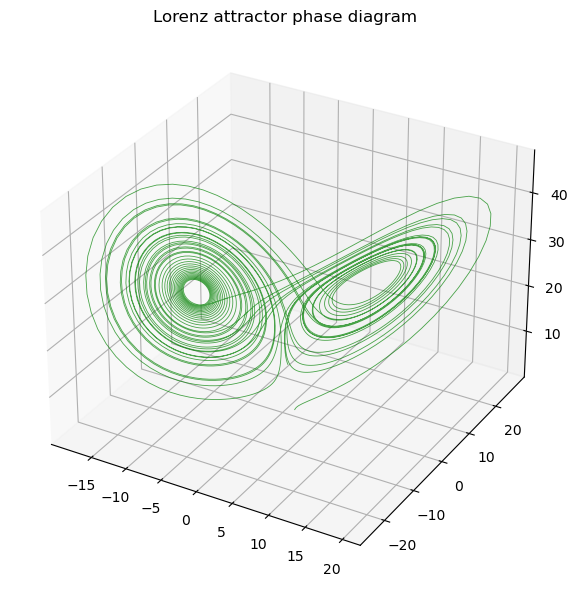

In [2]:
P = {'sigma': 10, 'beta': 8/3, 'rho': 28, 'dt': 0.01, 'n': 40}
V = [1.5, 0.6, 0.7]

T = ode_utils.iterate(ode_utils.lorentz_ode, V, **P)

# extract the individual arrays of x, y, and z values from the array of arrays
x, y, z = tuple(T.T)


# plot the lorenz attractor in three-dimensional phase space
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, color='g', alpha=0.7, linewidth=0.6)
ax.set_title('Lorenz attractor phase diagram')

# fig.savefig('{}/lorenz-attractor-3d.png'.format(save_folder), dpi=180, bbox_inches='tight')
plt.tight_layout()

# plt.show()

In [3]:
Tmin = np.min(T)
Tmax = np.max(T)
print(Tmin, Tmax)

-24.32974635665973 47.975443139769396


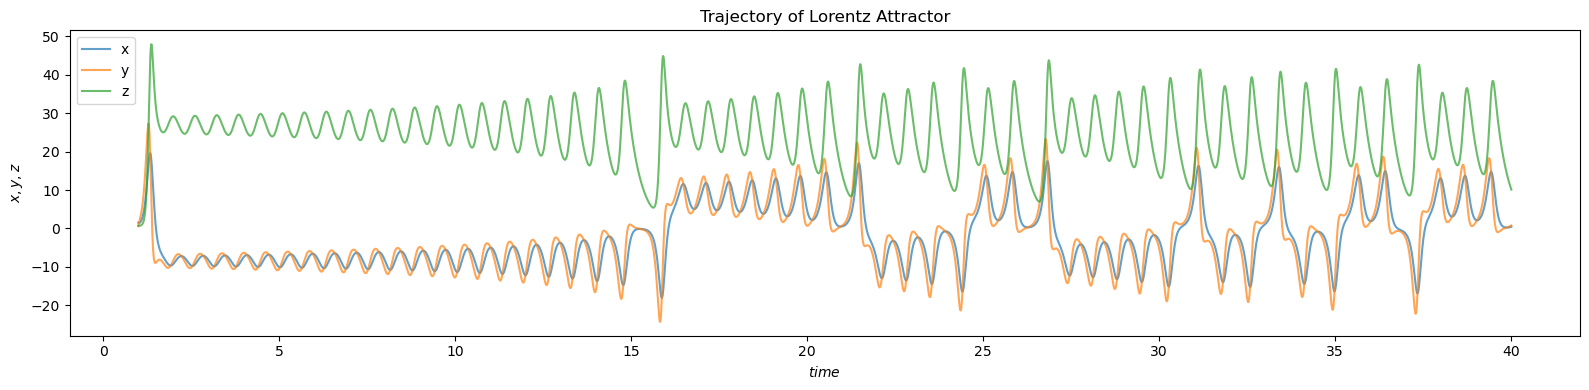

In [4]:
n = P['n']
dt = P['dt']
time = np.arange(1.0, n + dt + dt, dt)

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(time, x, label='x', alpha=0.7)
ax.plot(time, y, label='y', alpha=0.7)
ax.plot(time, z, label='z', alpha=0.7)
ax.set_title(f'Trajectory of Lorentz Attractor')
ax.set_xlabel('$time$')
ax.set_ylabel('$x, y, z$')
# ax.set_yscale('log')
ax.legend(loc="upper left")
plt.tight_layout()


## Model and train



In [5]:
class Model3N3(nn.Module):

    def name(self):
        return self._get_name()

    def __init__(self, num_hidden_units):
        super(Model3N3, self).__init__()

        self.fc1 = nn.Linear(3, num_hidden_units, bias=True)
        # self.fc2 = nn.Linear(num_hidden_units, num_hidden_units)
        self.fc3 = nn.Linear(num_hidden_units, 3, bias=True)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class MpsDataset(torch.utils.data.Dataset):
    
    def __init__(self, X: np.ndarray, Y: np.ndarray, device: torch.device):
        self.X = X
        self.Y = Y
        self.device = device if isinstance(device, torch.device) else torch.device(device)
        if not self.device == torch.device('mps'):
            print(f'overruling MPS device, using {self.device}')
    
    def __getitem__(self, idx):
        if self.device == torch.device('mps'):
            # cast data type to float32
            return torch.tensor(self.X[:,idx], dtype=torch.float32), torch.tensor(self.Y[:,idx], dtype=torch.float32)
        else:
            return torch.tensor(self.X[:,idx]), torch.tensor(self.Y[:,idx])
        
    def __len__(self): return len(self.Y)


def train(config, device, Tmin=0., Tmax=1.):
    torch_utils.reset_seed(config.seed)

    # create train data (x, y, z)
    n_steps = int(config.num_samples**(1./3.))
    x = np.linspace(-30., 30., n_steps)
    y = np.linspace(-30., 30., n_steps)
    z = np.linspace(0., 50., n_steps)

    X_train = np.vstack(np.meshgrid(x,y,z)).reshape(3,-1)
    Y_train = ode_utils.rk4(ode_utils.lorentz_ode, X_train, t=1.0, **config.parameters)


    # train_dataset = torch_utils.MpsDataset(X_train, Y_train, device)
    train_dataset = MpsDataset(X_train, Y_train, device)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / config.batch_size)

    # init model
    model = Model3N3(config.num_hidden_units)
    model.to(config.device)

    # Make the loss and optimizer
    loss_fn = torch.nn.MSELoss(reduction='sum')
    if hasattr(config, 'weight_decay'):
        optimizer = torch.optim.Adam(params=model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=config.learning_rate)
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loss=[]
    train_accuray=[]

    example_ct = 0
    # step_ct = 0
    for epoch in range(config.epochs):
        with tqdm(train_loader, unit=" batch") as tepoch:
            for step, (X, Y) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch}")
                
                X, Y = X.to(device=config.device), Y.to(device=config.device)
                # print(X.shape, X)
                # print(Y.shape, Y)
                optimizer.zero_grad()
                Y_hat = model(X)
                # print(Y_hat.shape, Y_hat)
                loss = loss_fn(Y_hat, Y)
                loss.backward()
                optimizer.step()

                correct = (abs(Y_hat - Y)<0.01).sum().item()
                accuracy = correct / config.batch_size

                example_ct += len(Y)

                tepoch.set_postfix(loss=loss.item(), accuracy=100.*accuracy, examples=f'{round(example_ct/1000, 0)}K')

                train_loss.append(loss.item())

                train_accuray.append(accuracy)

    epoch_time = [x/n_steps_per_epoch for x in range(len(train_loss))]
    return model, epoch_time, train_loss, train_accuray
    

## Config

In [31]:
config = SimpleNamespace(
    # reproducability
    seed=33,
    
    # train model
    num_experiments=1,
    model_name="Model3N3",
    num_hidden_units=8,

    # train regime
    batch_size=256,
    epochs=350,

    # train data
    dataset="lorentz ode",
    map_name="lorentz_ode",
    parameters = {'sigma': 10, 'beta': 8/3, 'rho': 28, 'dt': 0.01},
    num_samples = 400*256,
    
    optimizer="Adam",
    learning_rate=6e-2,
    weight_decay=1e-8,

    # device
    device="mps",
    dtype="float32",
    num_workers=4,
    gpu_name="M1Pro GPU 16 Cores",
    mixed_precision=False,
    channels_last=False,
)

device  = torch_utils.get_device()
model, epoch_time, train_loss, train_accuracy = train(config, device, Tmin, Tmax)

pytorch using device: mps


Epoch 349: 100%|██████████| 1/1 [00:00<00:00, 93.20 batch/s, accuracy=3.52, examples=1.0K, loss=2.59e-9]


## Visualize loss

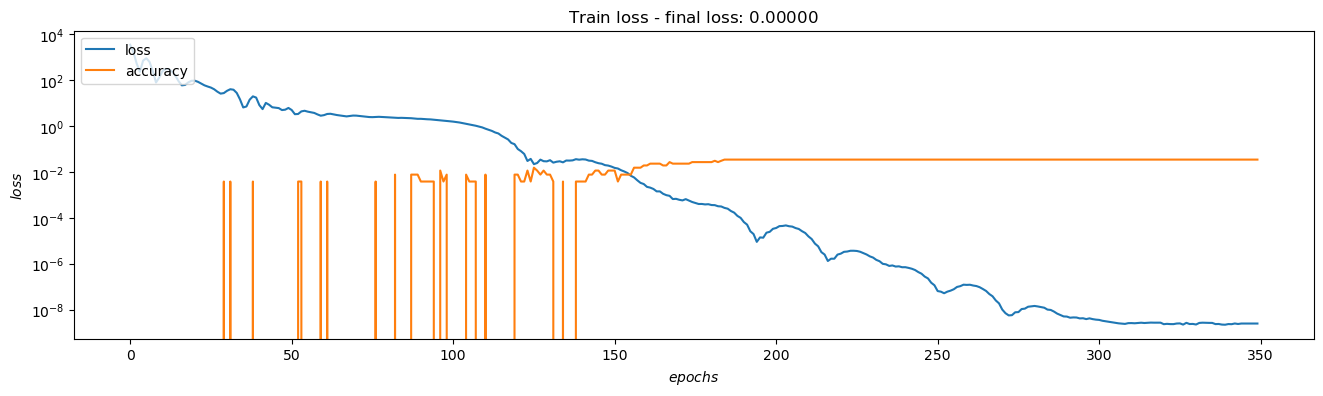

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(epoch_time, train_loss, label='loss')
ax.plot(epoch_time, train_accuracy, label='accuracy')
ax.set_title(f'Train loss - final loss: ${train_loss[-1]: .5f}$')
ax.set_xlabel('$epochs$')
ax.set_ylabel('$loss$')
ax.set_yscale('log')
# ax.set_ylim(0,0.1)

ax.legend(loc="upper left")
plt.show()

## Visualize actual vs predicted

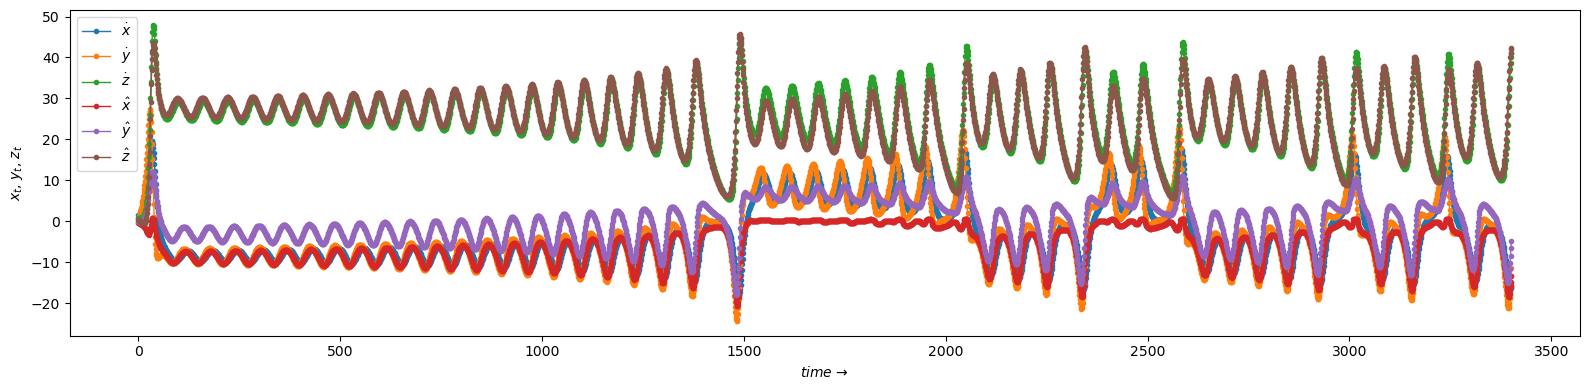

In [74]:
P = config.parameters
x0 = [1.5, 0.6, 0.7]

Y_dot = ode_utils.iterate(ode_utils.lorentz_ode, x0, n=35, **P)

X_torch = torch.tensor(Y_dot, dtype=torch.float32).to(config.device)
Y_hat = model(X_torch)
Y_hat = Y_hat.cpu().detach().numpy()

fig, ax1 = plt.subplots(1, 1, figsize=(16, 4))  #, gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

ax1.plot(Y_dot, marker='.', lw=1, label=['$\dot{x}$', '$\dot{y}$', '$\dot{z}$'])
ax1.plot(Y_hat, marker='.', lw=1, label=['$\hat{x}$', '$\hat{y}$', '$\hat{z}$'])

ax1.set_xlabel(f'$time$ $→$')
ax1.set_ylabel(f'$x_t$, $y_t$, $z_t$')
# ax1.legend(loc="upper left")
ax1.legend()

plt.tight_layout()

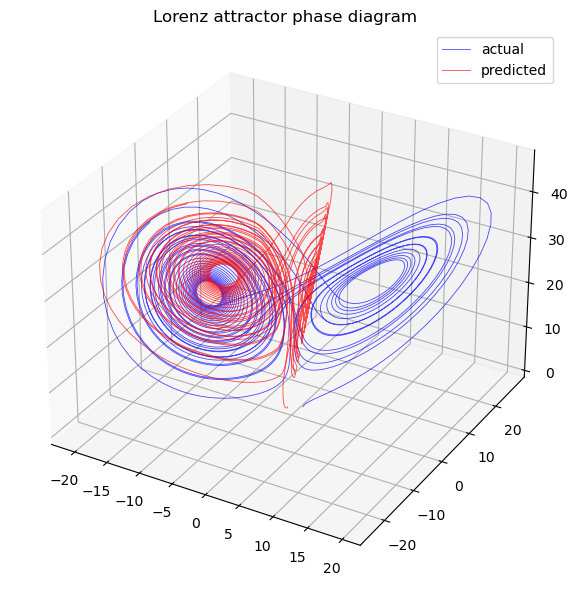

In [76]:
x_dot, y_dot, z_dot = tuple(Y_dot.T)
x_hat, y_hat, z_hat = tuple(Y_hat.T)

# plot the lorenz attractor in three-dimensional phase space
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot(x_dot, y_dot, z_dot, color='b', alpha=0.7, linewidth=0.6, label='actual')
ax.plot(x_hat, y_hat, z_hat, color='r', alpha=0.7, linewidth=0.6, label='predicted')
ax.set_title('Lorenz attractor phase diagram')
ax.legend()

# fig.savefig('{}/lorenz-attractor-3d.png'.format(save_folder), dpi=180, bbox_inches='tight')
plt.tight_layout()

## In progress - reading model parameters

In [46]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
print(model)
print(f'num_params: {num_params}')

Model3N3(
  (fc1): Linear(in_features=3, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
)
num_params: 59


In [47]:
for param in model.parameters():
    if param.requires_grad:
        print(param)

print('\n')

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.cpu().detach().numpy().flatten()}')

Parameter containing:
tensor([[ 3.9872e-01,  3.9760e-01, -4.1716e-01],
        [-3.8016e-01, -5.3619e-01, -1.4921e-01],
        [ 2.4321e-01, -3.2441e-01,  8.9574e-03],
        [-4.1677e-01, -2.6231e-01,  1.0882e-02],
        [-8.7766e-02,  7.0312e-01, -1.0432e+00],
        [-4.1150e-01, -4.5380e-01,  1.4809e-01],
        [ 5.0098e-01,  1.3708e-01, -9.9423e-01],
        [-1.4325e-03, -6.8993e-04,  2.0282e+00]], device='mps:0',
       requires_grad=True)
Parameter containing:
tensor([-3.9885e-01,  3.1915e-01,  4.4618e-01,  3.2524e-02, -7.7242e-05,
         5.8269e-01, -2.0391e-01,  1.2582e-02], device='mps:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.3977, -0.4594, -0.0593, -0.1715,  0.0727, -0.5105,  0.1377,  0.0117],
        [ 0.3979, -0.5534, -0.2357, -0.5293, -0.2271, -0.3552, -0.0722,  0.1331],
        [-0.3987,  0.0643,  0.1380,  0.1450, -0.0783,  0.1917,  0.0070,  0.4468]],
       device='mps:0', requires_grad=True)
Parameter containing:
tensor([-0.3532, -0.35